<a href="https://colab.research.google.com/github/parthnaik13/NYRA/blob/main/5_1_POC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC 2

In this notebook, we aim to follow along the footsteps of POC 1 to explore the relationship between race load that horses experience and its subsequent impact on their race performance (average race speed) using multi-variate modeling

## Things to look at in this modeling POC
* Do we directly model avg race speed or do we model the change in season avg for horses?
* Which confounding features to include?
* Do we get a good model?
* Do we see significance for race load features?
* Are the effects in the direction in which we would expect them to be?
* Can we quantify the effect of race load on avg race speed?
  * Ex - 14 more rest days lead to a 7.5% increase in avg race speed
  * Ex - 100 more furloghs lead to a 5% decrease in avg race speed

## Modeling steps

1. Load the nyra_race_horse_speed.csv data which is prepped in the `3.1_Data_Prep.ipynb` notebook
2. Create functions to calculate race-load features from the data
  * Cumulative volume in terms of race distance from season start
  * Avg rest intervals leading up to the race
3. Prepare the target
  * Let's try to model a ratio of $ \frac{Horse Race Speed_{i,j}}{Avg Horse Race Speed_{i}}$ which is essentially the ratio of a horse's speed in the current race to the avg race speed it had over the season
4. Analyze prepped target (can we do a linear regression for the target, the target ratios should look like a normal distribution)
5. Filter to just the typical races i.e. 'D' (dirt) and 'FT' (fast) tracks (avoid adding in more features to the model at this stage to capture speed variations due to track types)
6. Separate out a holdout set (for model validation)
7. Fit a linear regression model
  * Target - current to avg speed ratio
  * Features
    * Odds
    * Weight carried
    * Race-load features
8. Look at the fitted model summary
9. Is the model better than a naive model (model always predicting a 1)?


## Setup

* Mount google drive
* Load necessary python libraries

In [162]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
# Import necessary libs and print out their versions
import numpy as np
np.random.seed(7)

import pandas as pd
pd.set_option('display.max_columns', None) # Display all dataframe columns

import matplotlib
import matplotlib.pyplot as plt

import statsmodels
import sklearn

print(f'numpy version - {np.__version__}')
print(f'pandas version - {pd.__version__}')
print(f'matplotlib version - {matplotlib.__version__}')
print(f'statsmodels version- {statsmodels.__version__}')
print(f'sklearn version - {sklearn.__version__}')

numpy version - 1.21.6
pandas version - 1.3.5
matplotlib version - 3.2.2
statsmodels version- 0.12.2
sklearn version - 1.0.2


## Load prepped race data

Data prepped in the `3.1_Data_Prep.ipynb` notebook

In [164]:
# Load the data from the gdrive mount
nyra_df = pd.read_csv('/content/drive/MyDrive/NYRA_Data/nyra_race_horse_speed.csv', index_col = 0)
print(f'Shape of the dataframe - {nyra_df.shape}')
nyra_df.head(5)

Shape of the dataframe - (15080, 18)


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed
0,AQU,2019-01-01,1,3,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190
1,AQU,2019-01-01,1,4,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696
2,AQU,2019-01-01,1,5,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390
3,AQU,2019-01-01,1,1,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308
4,AQU,2019-01-01,1,2,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267


In [165]:
# Assign proper dtypes wherever needed
# Convert post_time to a datetime col (to extract the time part of things)
nyra_df['post_time'] = pd.to_datetime(nyra_df['post_time'])
# Incorporate the post time and convert this to a datetime column
nyra_df['race_date'] = pd.to_datetime(nyra_df['race_date'].astype(str) + ' ' + nyra_df['post_time'].dt.time.astype(str))
# post_time can now be dropped as its included in the race_date col
nyra_df = nyra_df.drop('post_time', axis = 1)
# race_number as a int/numeric col
nyra_df['race_number'] = pd.to_numeric(nyra_df['race_number'])

In [166]:
# Check of nulls (we don't have any, just in case)
nyra_df.isnull().sum().sum()

0

## Race load features
These features are indicative of the cumulative race load horses experience throughout the season

Brainstorm:
* Cumulative race distance (# of races ran since the start of the season)
* Avg # of days between races (experienced from the start of the season)
* Number of days/hours between previous and current race (did the horse get enough immediate rest)

### Calculate race load features

In [167]:
# Get race distance in miles
nyra_df['race_distance_miles'] = nyra_df['distance_id'] / 8 # Conversion of furlongs to miles
nyra_df['race_distance_miles'].describe()

count    15080.000000
mean        90.718667
std         18.820992
min         56.250000
25%         75.000000
50%         87.500000
75%        100.000000
max        250.000000
Name: race_distance_miles, dtype: float64

In [168]:
# Function to calculate cumulative race load which can be applied over horse groups
def race_load_features(horse_df):
  """
  Function to calculate
    * cumulative race distance given the race data for a horse
    * average time between races (in days)
    * time between the last and the current race
  
  Input: Horse race data (for a specific horse)

  Output: Race load features in the form of a dataframe (to be joined with the original df by index)

  Note: Race load features are at a race-level (calculated by looking at collective races for horses)
  """

  # Sort races by race_date
  horse_df = horse_df.sort_values(by = 'race_date', ascending = True)
  
  # Cumulative race distance

  # Get previous race distance col (we don't want to include the current race distance as the horse is yet to run)
  horse_df['prev_race_distance'] = horse_df['race_distance_miles'].shift(1)
  # Replace NaNs with 0s (first race of the season)
  horse_df = horse_df.fillna(0)
  # Get the cumulative previous race/s distance
  horse_df['cum_prev_race_distance'] = horse_df['prev_race_distance'].cumsum()

  # Get average time between races and the time from the last to current race (in days)

  # Get a previous race distance
  horse_df['prev_race_date'] = horse_df['race_date'].shift(1)
  horse_df['time_from_last_race'] = (horse_df['race_date'] - horse_df['prev_race_date']).dt.days
  # Fill NaNs with 0s (first race of the season doesn't have a previous race)
  horse_df = horse_df.fillna(0)
  # Get average of the all the previous time_from_last_race for a horse
  horse_df['prev_race_count'] = [i for i in range(0, horse_df.shape[0])]
  horse_df['time_from_last_race_cumsum'] = horse_df['time_from_last_race'].cumsum()
  horse_df['avg_time_from_last_race'] = horse_df['time_from_last_race_cumsum'] / horse_df['prev_race_count']
  horse_df['avg_time_from_last_race'] = horse_df['avg_time_from_last_race'].fillna(0) # For the first race of the race season for the horse

  return horse_df[['cum_prev_race_distance', 'avg_time_from_last_race', 'time_from_last_race']]

In [169]:
# Get the cum_prev_race_distance for horses across races using the above function (join with nyra_df using the index)
race_load_df = nyra_df.groupby('horse_id').apply(race_load_features).reset_index().set_index('level_1')
# Shape of the df
print(f'Shape of the df - {race_load_df.shape}')
race_load_df.head(5)

Shape of the df - (15080, 4)


,horse_id,cum_prev_race_distance,avg_time_from_last_race,time_from_last_race
level_1,,,,
2,0,0.00,0.000000,0.0
7570,0,81.25,145.000000,145.0
8444,0,181.25,82.000000,19.0
12474,0,256.25,66.666667,36.0
13907,0,325.00,56.000000,24.0


In [170]:
# Look for nulls in the race_load_df
race_load_df.isnull().sum().sum()

0

### Look at the distributions of the race load features

count    15080.000000
mean       202.500000
std        238.537386
min          0.000000
25%          0.000000
50%        112.500000
75%        306.250000
max       1762.500000
Name: cum_prev_race_distance, dtype: float64


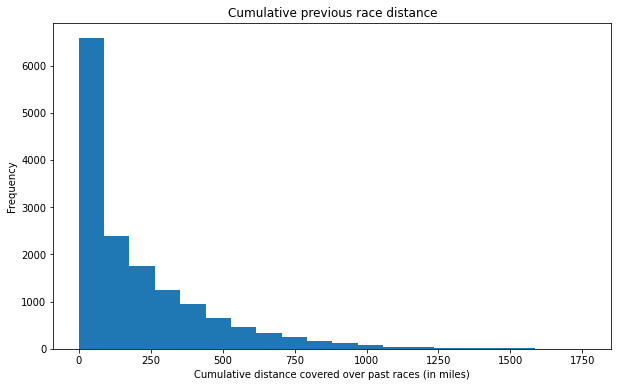

In [171]:
# Cumulative distance covered in the previous races
print(race_load_df['cum_prev_race_distance'].describe())
# Generate the plot
plt.figure(figsize = (10,6))
plt.hist(race_load_df['cum_prev_race_distance'], bins = 20)
plt.xlabel('Cumulative distance covered over past races (in miles)')
plt.ylabel('Frequency')
plt.title('Cumulative previous race distance')
plt.show()

count    15080.000000
mean        25.970114
std         27.022233
min          0.000000
25%          0.000000
50%         25.000000
75%         36.666667
max        336.000000
Name: avg_time_from_last_race, dtype: float64


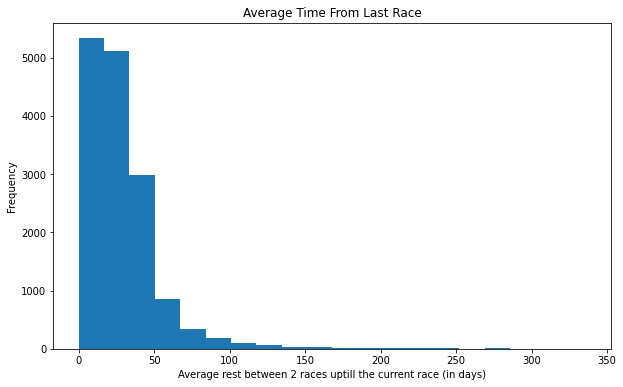

In [172]:
# Average rest time (avg_time_from_last_race)
print(race_load_df['avg_time_from_last_race'].describe())
# Generate the plot
plt.figure(figsize = (10,6))
plt.hist(race_load_df['avg_time_from_last_race'], bins = 20)
plt.xlabel('Average rest between 2 races uptill the current race (in days)')
plt.ylabel('Frequency')
plt.title('Average Time From Last Race')
plt.show()

count    15080.000000
mean        26.405637
std         33.140778
min          0.000000
25%          0.000000
50%         21.000000
75%         35.000000
max        347.000000
Name: time_from_last_race, dtype: float64


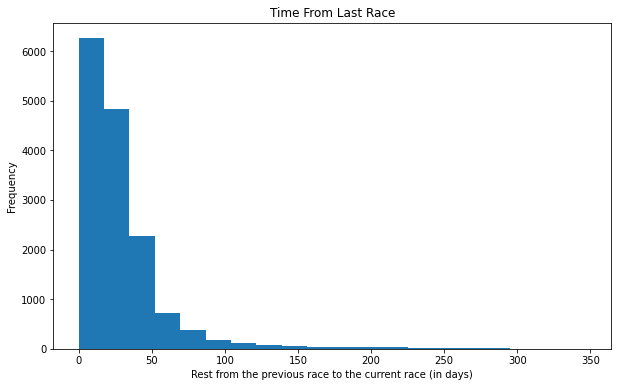

In [173]:
# Rest time since the last race (time_from_last_race)
print(race_load_df['time_from_last_race'].describe())
# Generate the plot
plt.figure(figsize = (10,6))
plt.hist(race_load_df['time_from_last_race'], bins = 20)
plt.xlabel('Rest from the previous race to the current race (in days)')
plt.ylabel('Frequency')
plt.title('Time From Last Race')
plt.show()

### Join the race load features with the main df

In [175]:
# Join race_load_df and nyra_df on the index
nyra_df = nyra_df.join(race_load_df[['cum_prev_race_distance', 'avg_time_from_last_race', 'time_from_last_race']], how = 'inner')
# Look at the shape of the df
print(f'Shape of the df - {nyra_df.shape}')
# Check for nulls
print(f'Nulls - {nyra_df.isnull().sum().sum()}')
nyra_df.head(5)

Shape of the df - (15080, 21)
Nulls - 0


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed,race_distance_miles,cum_prev_race_distance,avg_time_from_last_race,time_from_last_race
0,AQU,2019-01-01 12:20:00,1,3,650,D,MY,36,AOC,80000,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190,81.25,0.0,0.0,0.0
1,AQU,2019-01-01 12:20:00,1,4,650,D,MY,36,AOC,80000,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696,81.25,0.0,0.0,0.0
2,AQU,2019-01-01 12:20:00,1,5,650,D,MY,36,AOC,80000,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390,81.25,0.0,0.0,0.0
3,AQU,2019-01-01 12:20:00,1,1,650,D,MY,36,AOC,80000,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308,81.25,0.0,0.0,0.0
4,AQU,2019-01-01 12:20:00,1,2,650,D,MY,36,AOC,80000,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267,81.25,0.0,0.0,0.0


## Prepare the target

$Target = \frac{\text{Speed in current race for horse}_i}{\text{Avg speed across all races for horse}_i}$

* In order to account for the change in speed rather than just the race speed which can vary by horses, we model the ratio of the race speed for a horse to the average speed we recorded for that horse
* So a 0.8 target would indicate that $horse_i$ was 20% slower than its average speed in the race of interest

In [118]:
# Get the average speeds for horses across races


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed,race_distance_miles
0,AQU,2019-01-01 12:20:00,1,3,650,D,MY,36,AOC,80000,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190,81.25
872,AQU,2019-02-01 22:03:00,4,3,600,D,FT,40,AOC,75000,121,Manuel Franco,375,3,3,Friend of Liberty,41.134602,75.00
7661,BEL,2019-05-30 05:42:00,6,3,600,D,GD,48,CLM,55000,123,Manuel Franco,420,3,4,Friend of Liberty,41.836750,75.00
